## DS 6120, 6130: Capstone A and B
## Identifying Complex Metadata Relationships to Objects using Natural Language Processing and Image Classification
## Authors: Anand Rajan, Benjamin Wilke, and Tej Tenmattam

---

# 1. Download the dataset and import the required libraries

In [ ]:
# Get the Flickr text dataset
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
# Get the Flickr photos dataset
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
# Download GloVe: Global Vectors for Word Representation
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip the downloaded files
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip
!unzip glove.6B.zip

In [1]:
# Import the necessary libraries for this project

import string
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from os import listdir
from os import path
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.resnet50 import ResNet50
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras import Input, layers
from keras import optimizers
from time import time
from PIL import Image

Using TensorFlow backend.


In [2]:
# Capture the time
start = time()

# 2. Data Preparation

In [3]:
# The file Flickr8k.token.txt contains a list of image identifiers and their tokenized descriptions. 
# Each image has multiple descriptions. Below is a sample of the descriptions from the file showing 5 different descriptions for a single image.

def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [4]:
# Below function will take the loaded file, process it line-by-line, and return a dictionary of image identifiers to their first description.

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
descriptions['1000268201_693b08cb0e']

#{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
#  'A girl going into a wooden building .',
# 'A little girl climbing into a wooden playhouse .',
# 'A little girl climbing the stairs to her playhouse .',
# 'A little girl in a pink dress going into a wooden cabin .'],
# '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',  .......
                           

Loaded: 8092 


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [5]:
# The descriptions are tokenized which mean that each token is comprised of words separated by white space and also punctuation are separated as tokens, such as periods (‘.’) and apostrophes.
# For data cleaning we can change the case of all tokens to lowercase.
# Remove all punctuation from tokens.
# Remove all tokens that contain one or fewer characters.

def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
   
# clean descriptions
clean_descriptions(descriptions)
descriptions['1000268201_693b08cb0e']

#{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
#  'girl going into wooden building',
#  'little girl climbing into wooden playhouse',
#  'little girl climbing the stairs to her playhouse',
#  'little girl in pink dress going into wooden cabin'],
# '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',  .......
                           

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [6]:
# We will now convert the loaded descriptions into a vocabulary of words

def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]     #<-- splits description into tokens, only adds new to set()
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


In [7]:
# We will now save the clean text to file for later use by our model. Each line will contain the image identifier followed by the clean description.

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 
# save descriptions to file
save_descriptions(descriptions, 'descriptions.txt')

#1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
#1000268201_693b08cb0e girl going into wooden building
#1000268201_693b08cb0e little girl climbing into wooden playhouse
#1000268201_693b08cb0e little girl climbing the stairs to her playhouse
#1000268201_693b08cb0e little girl in pink dress going into wooden cabin


# 3. Extract image features using pre-trained CNN Models 

In [ ]:
# Run this code cell for VGG16 only

# We will use the pre-trained CNN models to extract the features from the images
# We will remove the last layer from the loaded model, as VGG16 is a model used to predict a classification for a photo. 
# We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
# These are the features that the model has extracted from the photo.

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
 
  # Below we will remove the last layer from the loaded model, as VGG16 is a model used to predict a classification for a photo. 
  # We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. 
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    model.summary()
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
    # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))    # changes shape from (224, 224, 3) to (1, 224, 224, 3)
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)   # outputs feature vector that is shape (1,4096) as outlined in the model.summary() last dense layer 
        # get image id
        image_id = name.split('.')[0]  # get just name and not extension
        # store feature
        features[image_id] = feature   # add dict() entry with name of image_id and value of feature
        print('>%s' % name)
    return features

# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save the extracted features to a file
dump(features, open('features_vgg16.pkl', 'wb'))



In [8]:
# load features from file
features = load(open('features_vgg16.pkl', 'rb'))


# 4. Load prepared data

In [13]:
# Training and testing dataset are predefined in the Flickr_8k.trainImages.txt and Flickr_8k.testImages.txt files respectively, 
# They contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]     #<--- get only the name, leave .jpg
        dataset.append(identifier)
    return set(dataset)     # <--- ensures that the output is unique filenames
 
# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# load test set (1k)
filename = 'Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 6000
Dataset: 1000


In [14]:
# Below function loads the cleaned text descriptions from descriptions.txt 
# The model will generate a caption given a photo, and the caption will be generated one word at a time. 
# The sequence of previously generated words will be provided as input. Therefore, we will need a first word to kick-off the generation process and a last word to signal the end of the caption. 
# We will use the strings startseq and endseq for this purpose. These tokens are added to the loaded descriptions as they are loaded.

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:                   # <-- if in train vs. test list
            # create list
            if image_id not in descriptions:        # <-- if image_id doesn't already exist
                descriptions[image_id] = list()     # <-- then create a key for it and initialize a list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  # <-- reform description and wrap
            # store
            descriptions[image_id].append(desc)     # <-- add formed description at key
    return descriptions

# load training descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# load test descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: train=%d' % len(test_descriptions))

Descriptions: train=6000
Descriptions: train=1000


In [19]:
# Next, we will load the photo features for a given dataset. 
# Below function loads the entire set of photo descriptions, then will return a subset depeding on train or test.

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))       #<-- open features file
    # filter features
    features = {k: all_features[k] for k in dataset}   #<-- dictionary comprehension for filtering based on dataset
    return features

# train photo features
train_features = load_photo_features('features_vgg16.pkl', train)
print('Photos: train=%d' % len(train_features))

# test photo features
test_features = load_photo_features('features_vgg16.pkl', test)
print('Photos: train=%d' % len(test_features))

Photos: train=6000
Photos: train=1000


# 5. Encode the data

In [20]:
# Next, we will have to encode to numbers the description text before we can present it to the model as an input
# The first step in encoding the data is to create a mapping from words to unique integer values.

# convert a dictionary of clean descriptions to a list of descriptions
# basically adds each description from each image to each other to make one long list of all descriptions strings
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)   #<-- adds each description from each image to each other to make one long list of all descriptions
    tokenizer = Tokenizer()          #<-- instantiate Tokenizer() object
    tokenizer.fit_on_texts(lines)    #<-- fit tokenizer on list of lists 
    return tokenizer

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [21]:
# Next, we will calculate the maximum number of words in the longest description.
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)  #<-- examine each line, split into words, return max length of words
 
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Sequency Length: %d' % max_length)

# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  #<-- word_index is {'startseq': 1,'endseq': 2, in': 3, 'the': 4, ... }
print('Vocabulary Size: %d' % vocab_size)

#tokenizer.word_index
#
# {'startseq': 1,
# 'endseq': 2,
# 'in': 3,
# 'the': 4,
# 'on': 5,   .....


Max Sequency Length: 34
Vocabulary Size: 7579


In [22]:
# Next, we will encode the text. Each description will be split into words. 
# The model will be provided one word and the photo and generate the next word. 
# Then the first two words of the description will be provided to the model as input with the image to generate the next word.
# Then three words, etc. ...

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():     #<-- for each key and list of descriptions
        for desc in desc_list:                      #<-- for each description in list of descriptions
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]  #<-- converts to [8, 869, 74, 167, 65, 4, 306, 26, 37, 89, 19, 154]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):                   #<-- iterate over the length of the sequence
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]   #<-- in_seq is everything up to index, out_seq is index
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  #<-- input sequences must be same length!
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  #<-- since out_seq is single digit, one-hot encodes 
                # store
                X1.append(photos[key][0])    #<-- store the learned image feature
                X2.append(in_seq)            #<-- store the current in_seq
                y.append(out_seq)            #<-- store the expected out_seq
    return array(X1), array(X2), array(y)    #<-- return as Numpy array
 
# prepare sequences for training
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

# prepare sequences for test
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

# 6. Create Word Embeddings (GLOVE)

In [23]:
# Create a list of training captions - #<-- this does the same thing as to_lines function above
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [24]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:         #<-- for each caption in all_train_captions
    nsents += 1
    for w in sent.split(' '):           #<-- split each caption by space and return each word        
        word_counts[w] = word_counts.get(w, 0) + 1   #<-- at key of word, get either current value or zero if newly created...add 1.

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]  #<-- lookup word_counts by word, compare to threshold, if over 10 return word
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [25]:
# create index to word and word to index 
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [26]:
# Load Glove model
glove_dir = ''             #<-- empty because in root. 
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")  #<-- load Glove 200d 

# the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 .....

for line in f:
    values = line.split()                                     #<-- split each line by spaces
    word = values[0]                                          #<-- capture word, which is first value
    coefs = np.asarray(values[1:], dtype='float32')           #<-- form coef values into array (after 1)
    embeddings_index[word] = coefs                            #<-- insert into dictionary
f.close()                                                     #<-- close file
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:
# Run this cell only for Glove
embedding_dim = 200

# create 200-dim dense vector for each of the vocab_size words in our vocabulary (7579)
embedding_matrix = np.zeros((vocab_size, embedding_dim))   #<-- shape = (7579, 200), each word is represented by 200-dim embedding
embedding_matrix.shape

(7579, 200)

In [28]:
# this basically extracts only the embeddings that we need from the total embeddings provided by glove
for word, i in wordtoix.items():                       #<-- for each item in wordtoix dict get word and index 
    embedding_vector = embeddings_index.get(word)      #<-- lookup word in glove embeddings index, get embeddings
    if embedding_vector is not None:                   #<-- if lookup successful
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector         #<-- set embedding_matrix at position of index to glove embedding
        
# Get embedding matrix shape
embedding_matrix.shape

(7579, 200)

# 6. Build and fit the captioning model

In [29]:
# Captioning model expects input photo features to be a vector of 4,096 elements for vgg16.
# These are processed by a Dense layer to produce a 256 element representation of the photo.

# The Sequence Processor model expects input sequences with a pre-defined length (max_length) 
# which are fed into an Embedding layer that uses a mask to ignore padded values. 

# This is followed by an LSTM layer with 256 memory units.
# Both the input models produce a 256 element vector. 

# Both input models use regularization in the form of 50% dropout.
# This is to reduce overfitting the training dataset. 

# The Decoder model merges the vectors from both input models using an addition operation. 

# This is then fed to a Dense 256 neuron layer and then to a final output Dense layer 
# that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))                    #<-- shape of output of vgg16
    fe1 = Dropout(0.5)(inputs1)                       #<-- inputs fed to dropout
    fe2 = Dense(256, activation='relu')(fe1)          #<-- dropout fed to dense
    # sequence model
    inputs2 = Input(shape=(max_length,))              #<-- the shape of our longest sequence (34,)
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) #<-- input fed to embedding layer (7579,200)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])                        #<-- add together the image feature extractor and sequence model output
    decoder2 = Dense(256, activation='relu')(decoder1)#<-- feed to dense
    outputs = Dense(vocab_size, activation='softmax')(decoder2) #<-- feed to output dense using softmax
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

# define the model
model = define_model(vocab_size, max_length)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [31]:
# Layer 2 uses GLOVE Model
model.layers[2].set_weights([embedding_matrix])       #<-- overwrite the embedding weights
model.layers[2].trainable = False
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# summarize model
model.summary()

#import pydot
#plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [32]:
# Next, we will define a ModelCheckpoint in Keras and specify it to monitor the minimum loss on the validation dataset 
# and save the model to a file that has both the training and validation loss in the filename.

# define checkpoint callback
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [33]:
# Next, we will fit the model

# fit model
model.fit([X1train, X2train], ytrain, epochs=5, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Train on 306404 samples, validate on 50638 samples
Epoch 1/5
 - 514s - loss: 4.7945 - val_loss: 4.2450

Epoch 00001: val_loss improved from inf to 4.24501, saving model to model.h5
Epoch 2/5
 - 509s - loss: 4.1363 - val_loss: 4.0583

Epoch 00002: val_loss improved from 4.24501 to 4.05831, saving model to model.h5
Epoch 3/5
 - 508s - loss: 3.9270 - val_loss: 4.0207

Epoch 00003: val_loss improved from 4.05831 to 4.02067, saving model to model.h5
Epoch 4/5
 - 512s - loss: 3.8373 - val_loss: 4.0048

Epoch 00004: val_loss improved from 4.02067 to 4.00481, saving model to model.h5
Epoch 5/5
 - 514s - loss: 3.7826 - val_loss: 4.0081

Epoch 00005: val_loss did not improve from 4.00481


# 7. Evaluate the model

In [34]:
# Now that the model is fit, we will evaluate the skill of predictions on the test dataset.
# Below function passes in the start description token startseq, generates one word,
# then calls the model recursively with generated words as input until the end of sequence token is reached endseq
# or the maximum description length is reached. 

# map an integer to a word...kinda nasty..loops through whole word_index and evaluates each index
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [38]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'                                       #<-- seed the generation process
    for _ in range(max_length):                                #<-- iterate over the whole length of the sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]  #<-- for each iteration, integer encode input sequence
        sequence = pad_sequences([sequence], maxlen=max_length)#<-- then pad input for consistent length
        yhat = model.predict([photo,sequence], verbose=0)      #<-- predict next word
        yhat = argmax(yhat)                                    #<-- convert probability to integer
        word = word_for_id(yhat, tokenizer)                    #<-- map integer to word
        if word is None:                                       #<-- stop if we cannot map the word
            break
        in_text += ' ' + word                                  #<-- append as input for generating the next word
        if word == 'endseq':                                   #<-- stop if we predict the end of the sequence
            break
    return in_text

In [39]:
# Next, we will remove the special start and end of sequence words.
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [40]:
# Next, we will calculate BLEU scores for 1, 2, 3 and 4 cumulative n-grams.
# NLTK Python library implements the BLEU score calculation in the corpus bleu() function. 
# A higher score close to 1.0 is better, a score closer to zero is worse.

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # clean up prediction
        yhat = cleanup_summary(yhat)
        # store actual and predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load the model
filename = 'model.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

# 8. Generate new captions to capture metadata relationships to objects

In [42]:
# Next, we will generate captions to capture metadata relationships to objects.

# First , we load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# then set the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model.h5')

# Next, we create a variation of the extract_features function to just take in one image instead of whole directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

In [43]:
def generate_caption(filename):
    # load and prepare the photograph
    photo = extract_features(filename)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    description = cleanup_summary(description)
    # Display the image
    image = mpimg.imread(filename)
    plt.imshow(image)
    plt.show()
    # Display the caption
    print(description)

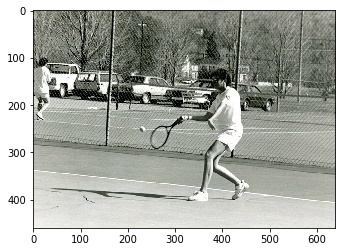

man in black shirt is standing on the street


In [44]:
generate_caption("ex1.jpg")

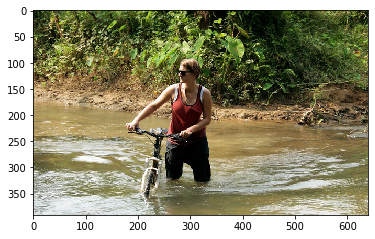

two children are playing in the water


In [45]:
generate_caption("ex2.jpg")

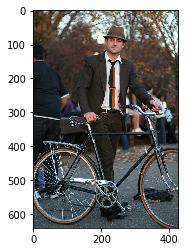

man in black shirt is standing on the ground


In [46]:
generate_caption("ex3.jpg")